# Imports, load data

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm, trange

from distance_determination import get_current_freq
from simul.utilities.data import load_experiment
from simul.vis.signals import vis_signals

In [5]:
from run_experiment import experiments

In [6]:
from distance_determination import estimate_dist, simulate_signals

In [9]:
exp_name = "not_moving"
params = experiments[exp_name]
dist, signals_data = simulate_signals(params)
# params, dist, signals_data, dist_probs = load_experiment("not_moving")

Simulating distances and signals:   0%|          | 0/23336 [00:00<?, ?it/s]

# VIS

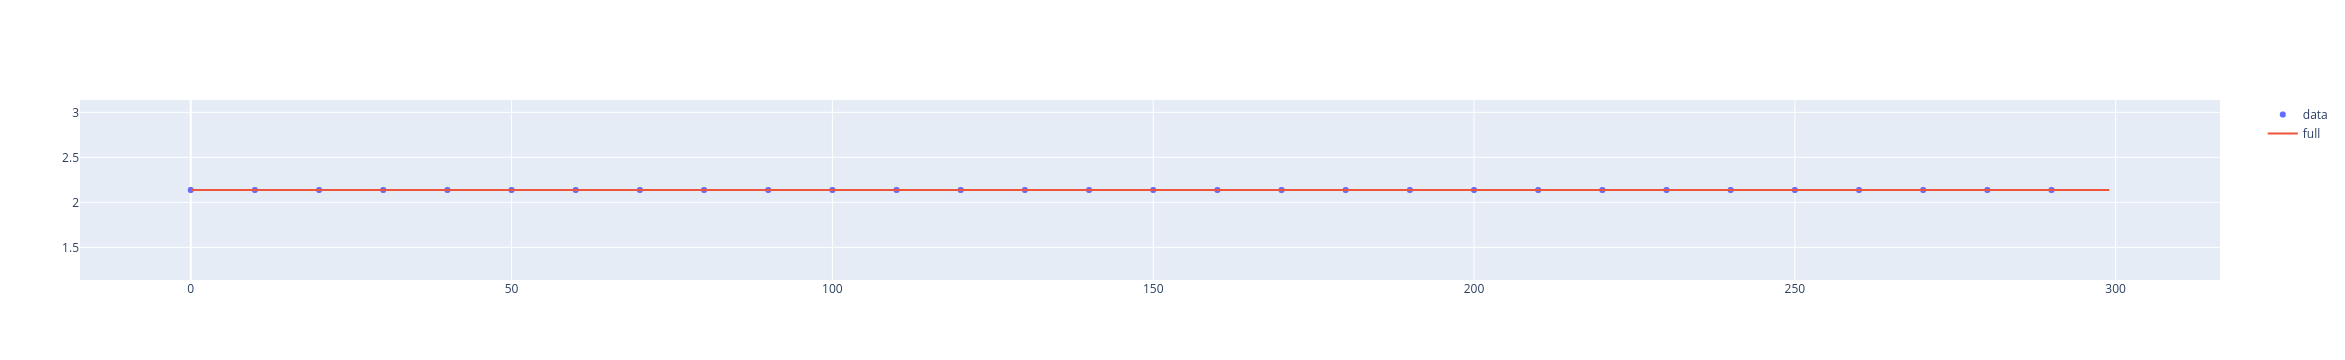

In [10]:
y = np.angle(signals_data[0, ...])
x = y.copy()

step = 10
x[[True if i % step else False for i in range(len(x))]] = np.nan


n = 300
fig = go.Figure()
fig.add_trace(go.Scatter(y=x[:n], name="data", mode="markers"))
fig.add_trace(go.Scatter(y=y[:n], name="full"))
fig

(40, 100) (40, 100) (40, 100) (100,) (40,)


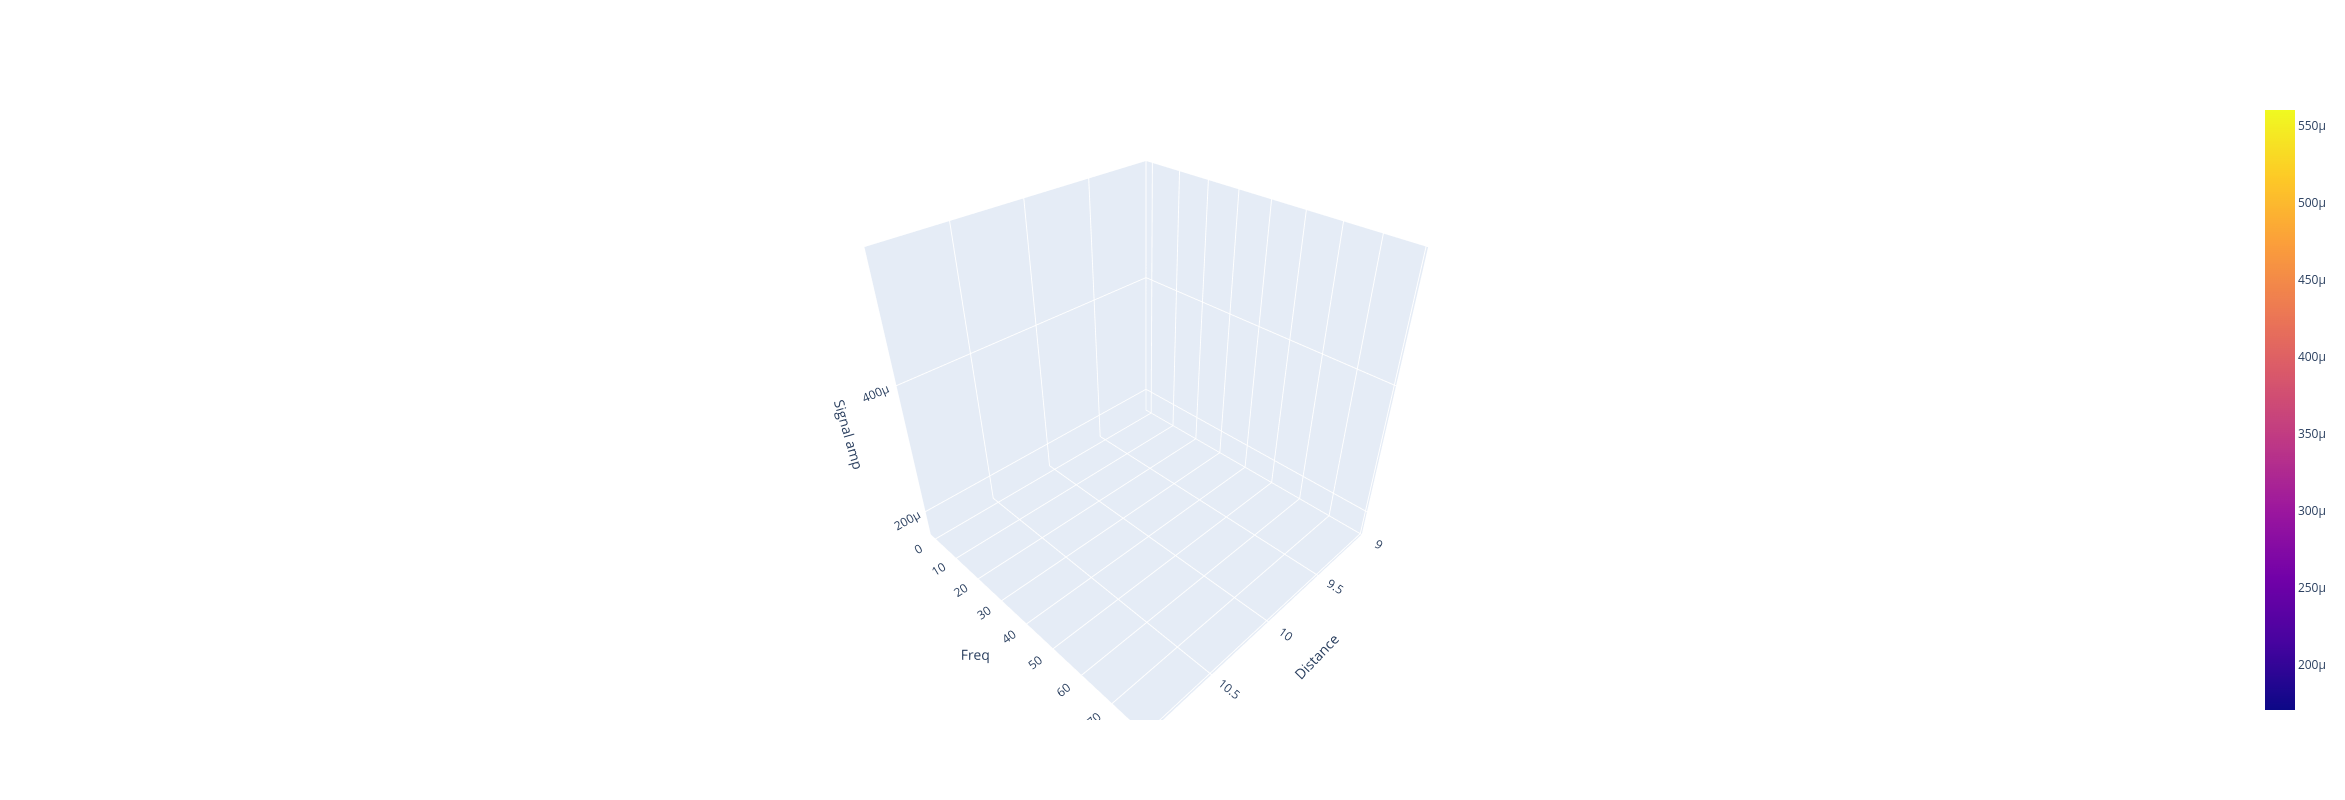

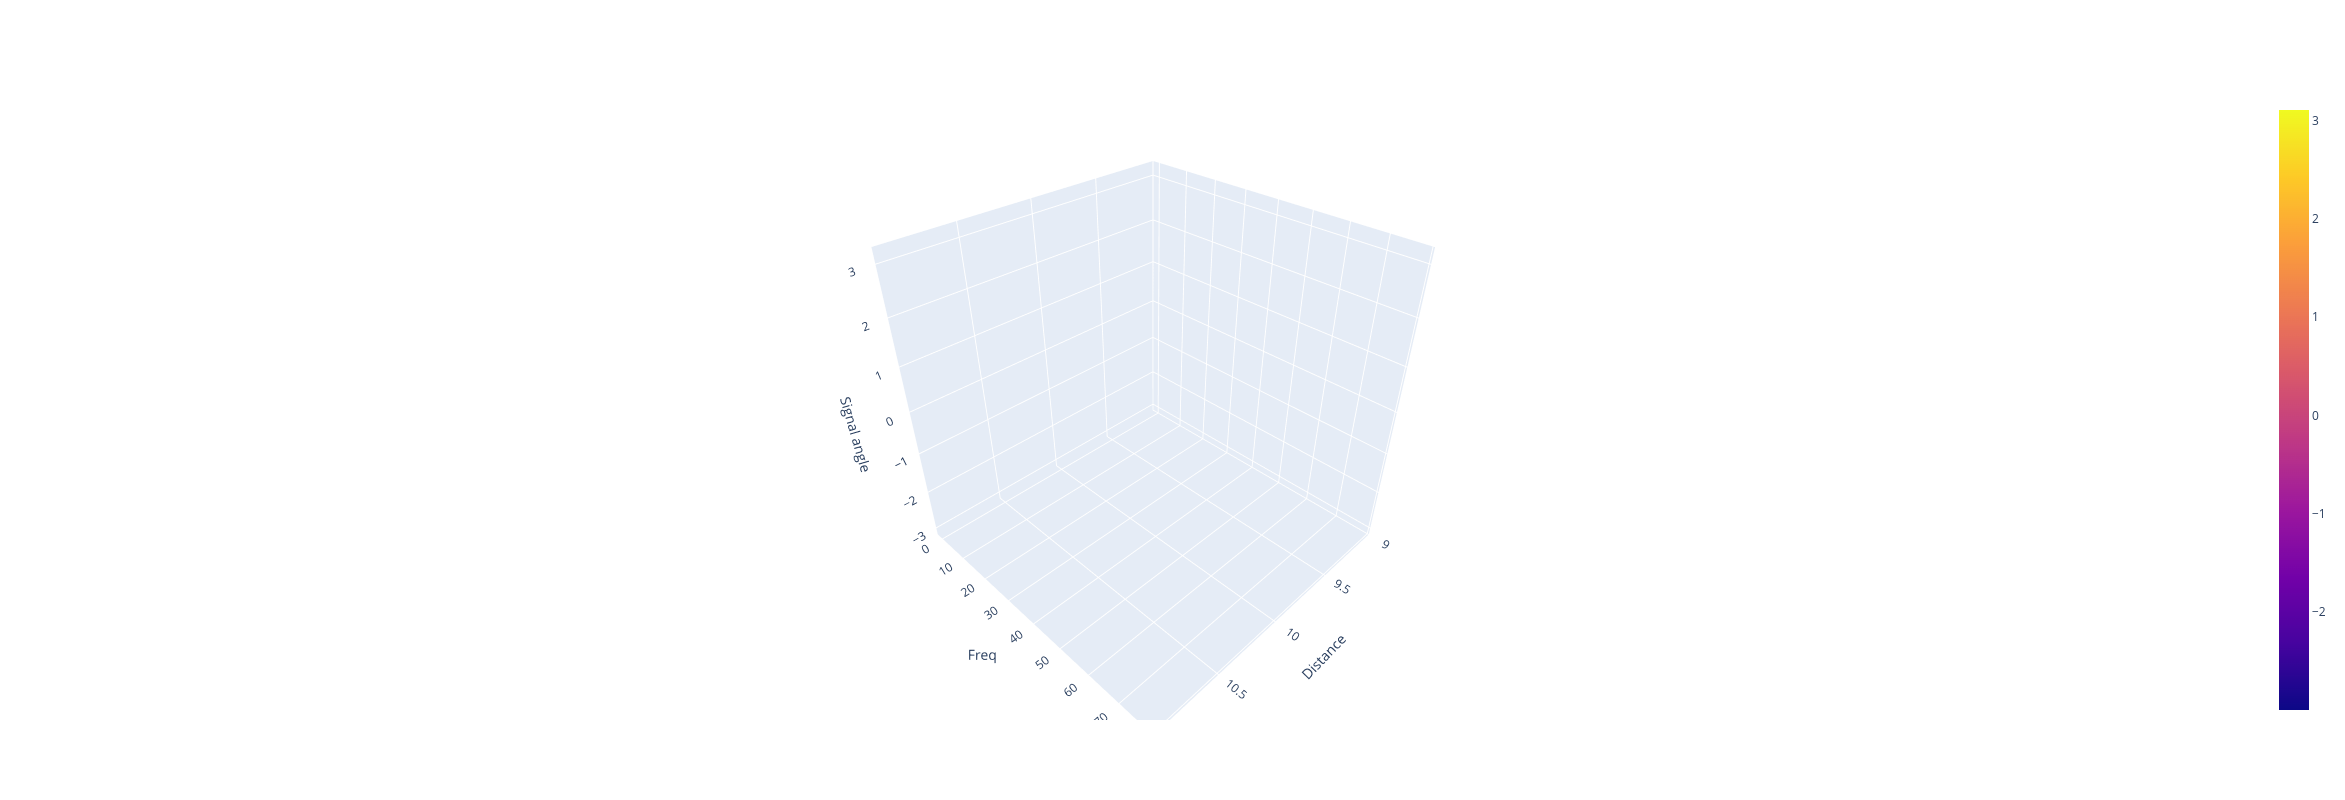

In [11]:
fig_amp, fig_angle, _ = vis_signals(signals_data, dist, params, 300, dump=True)

fig_amp.update_layout(height=800)
fig_amp.show()

fig_angle.update_layout(height=800)
fig_angle.show()

# Whittaker–Shannon

In [12]:
y.shape, np.sin(y).shape

((23336,), (23336,))

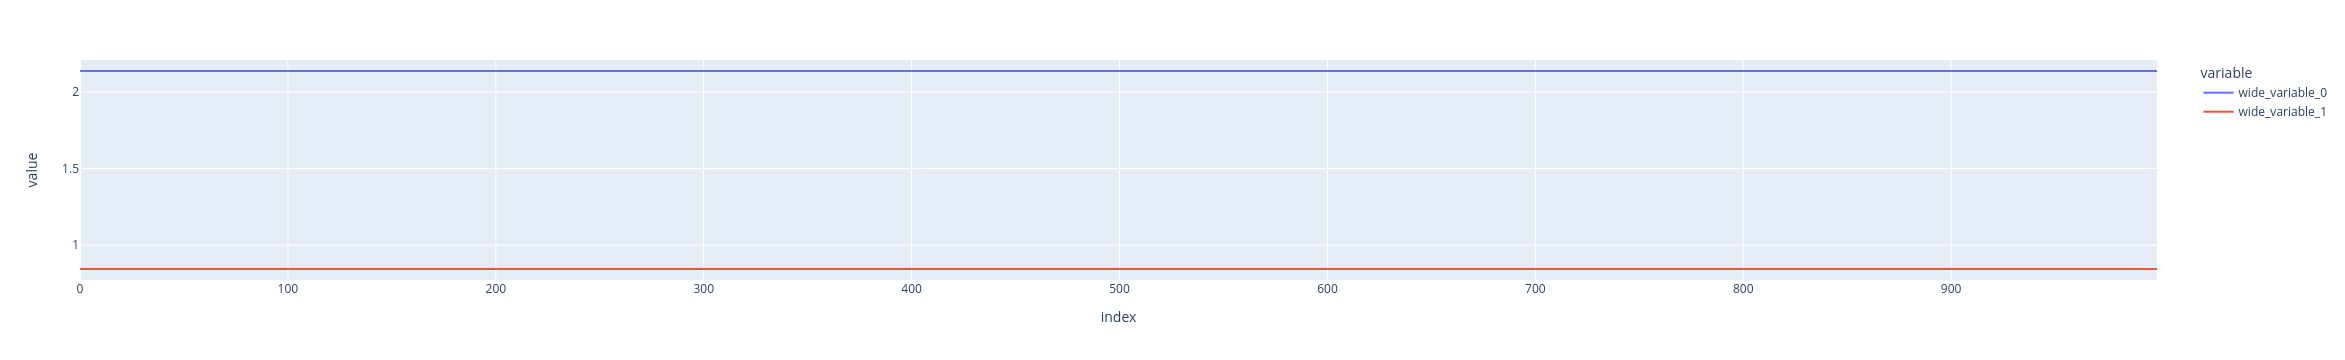

In [13]:
px.line(y=[y[:1000], np.sin(y[:1000])])

Interpolate complex value

Try with a single signal

In [14]:
def wsinterp(x, xp, fp, left=None, right=None):
    """One-dimensional Whittaker-Shannon interpolation.

    This uses the Whittaker-Shannon interpolation formula to interpolate the
    value of fp (array), which is defined over xp (array), at x (array or
    float).

    Returns the interpolated array with dimensions of x.

    """
    scalar = np.isscalar(x)
    if scalar:
        x = np.array(x)
        x.resize(1)
    # shape = (nxp, nx), nxp copies of x data span axis 1
    u = np.resize(x, (len(xp), len(x)))
    # Must take transpose of u for proper broadcasting with xp.
    # shape = (nx, nxp), v(xp) data spans axis 1
    v = (xp - u.T) / (xp[1] - xp[0])
    # shape = (nx, nxp), m(v) data spans axis 1
    m = fp * np.sinc(v)
    # Sum over m(v) (axis 1)
    fp_at_x = np.sum(m, axis=1)

    # Enforce left and right
    if left is None:
        left = fp[0]
    fp_at_x[x < xp[0]] = left
    if right is None:
        right = fp[-1]
    fp_at_x[x > xp[-1]] = right

    # Return a float if we got a float
    if scalar:
        return float(fp_at_x)

    return fp_at_x

In [41]:
xp = np.arange(0, 1000, 10) * 0.1

In [42]:
yp = np.sin(x)

1. Have test data (without the simulator)
2. Have the test simulated data (motion towards the beacon, velocity = +/-)

FFT with mirrors and increase number of measurements

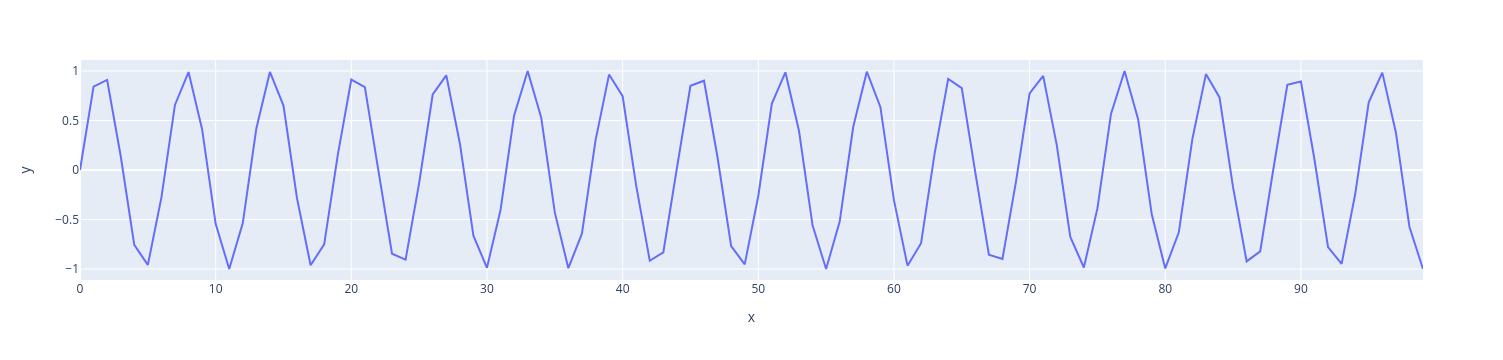

In [54]:
px.line(y=yp, x=xp)

In [44]:
x = np.arange(0, 10000, 10) * 0.01

In [48]:
f = wsinterp(x, xp, yp)

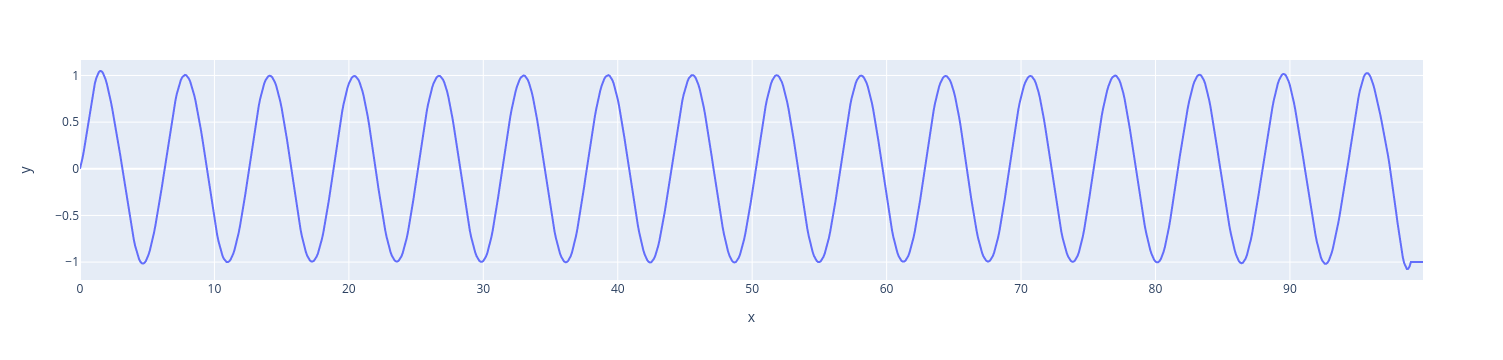

In [53]:
px.line(y=f, x=x)

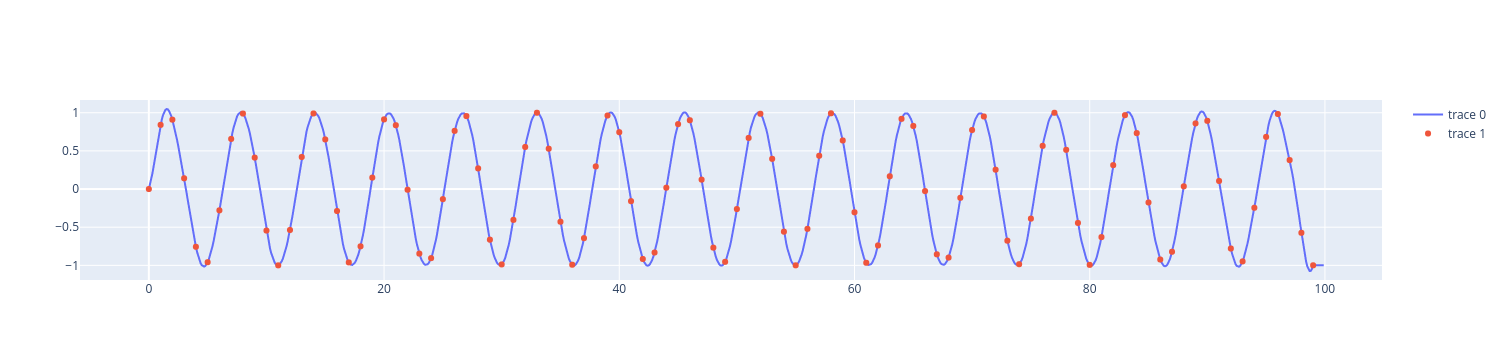

In [61]:
go.Figure(data=[go.Scatter(y=f, x=x), go.Scatter(y=yp, x=xp, mode='markers')])

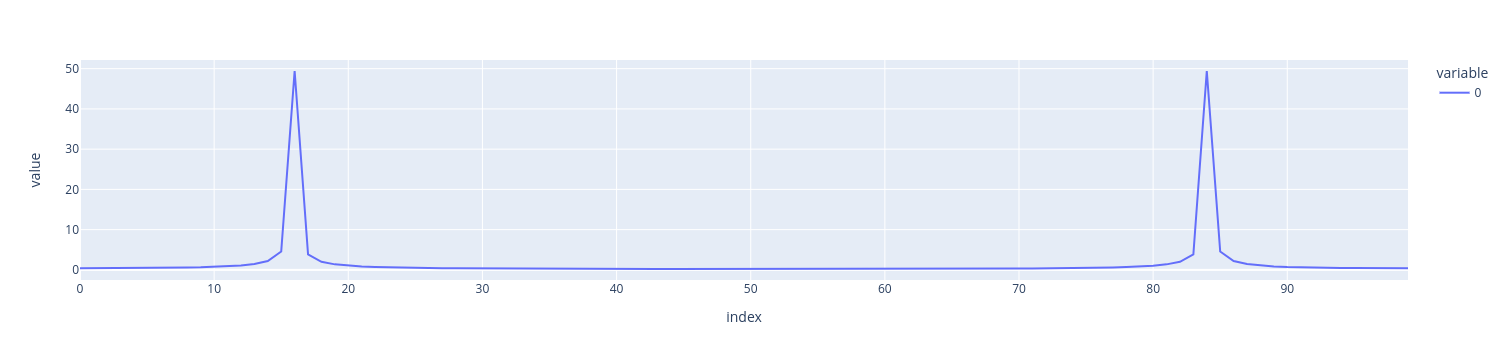

In [65]:
px.line(np.abs(np.fft.fft(yp)))

Add x and y scales(?)

Hz

Better fourier

Does it assume that the code is periodic?
Does it fill with zeros?

Create dataset of different types of signals.

Better storytelling

In [ ]:

wsinterp(np.arange(len(x)), np.squeeze(np.argwhere(~np.isnan(x))), x[~np.isnan(x)])

In [16]:
y = signals_data[0, ...]
interps = {"full": y}

for step in trange(2, 60, 10):
    x = y.copy()

    x[[True if i % step else False for i in range(len(x))]] = np.nan
    x_interp = wsinterp(
        np.arange(len(x)), np.squeeze(np.argwhere(~np.isnan(x))), x[~np.isnan(x)]
    )
    interps[step] = x_interp

  0%|          | 0/6 [00:00<?, ?it/s]

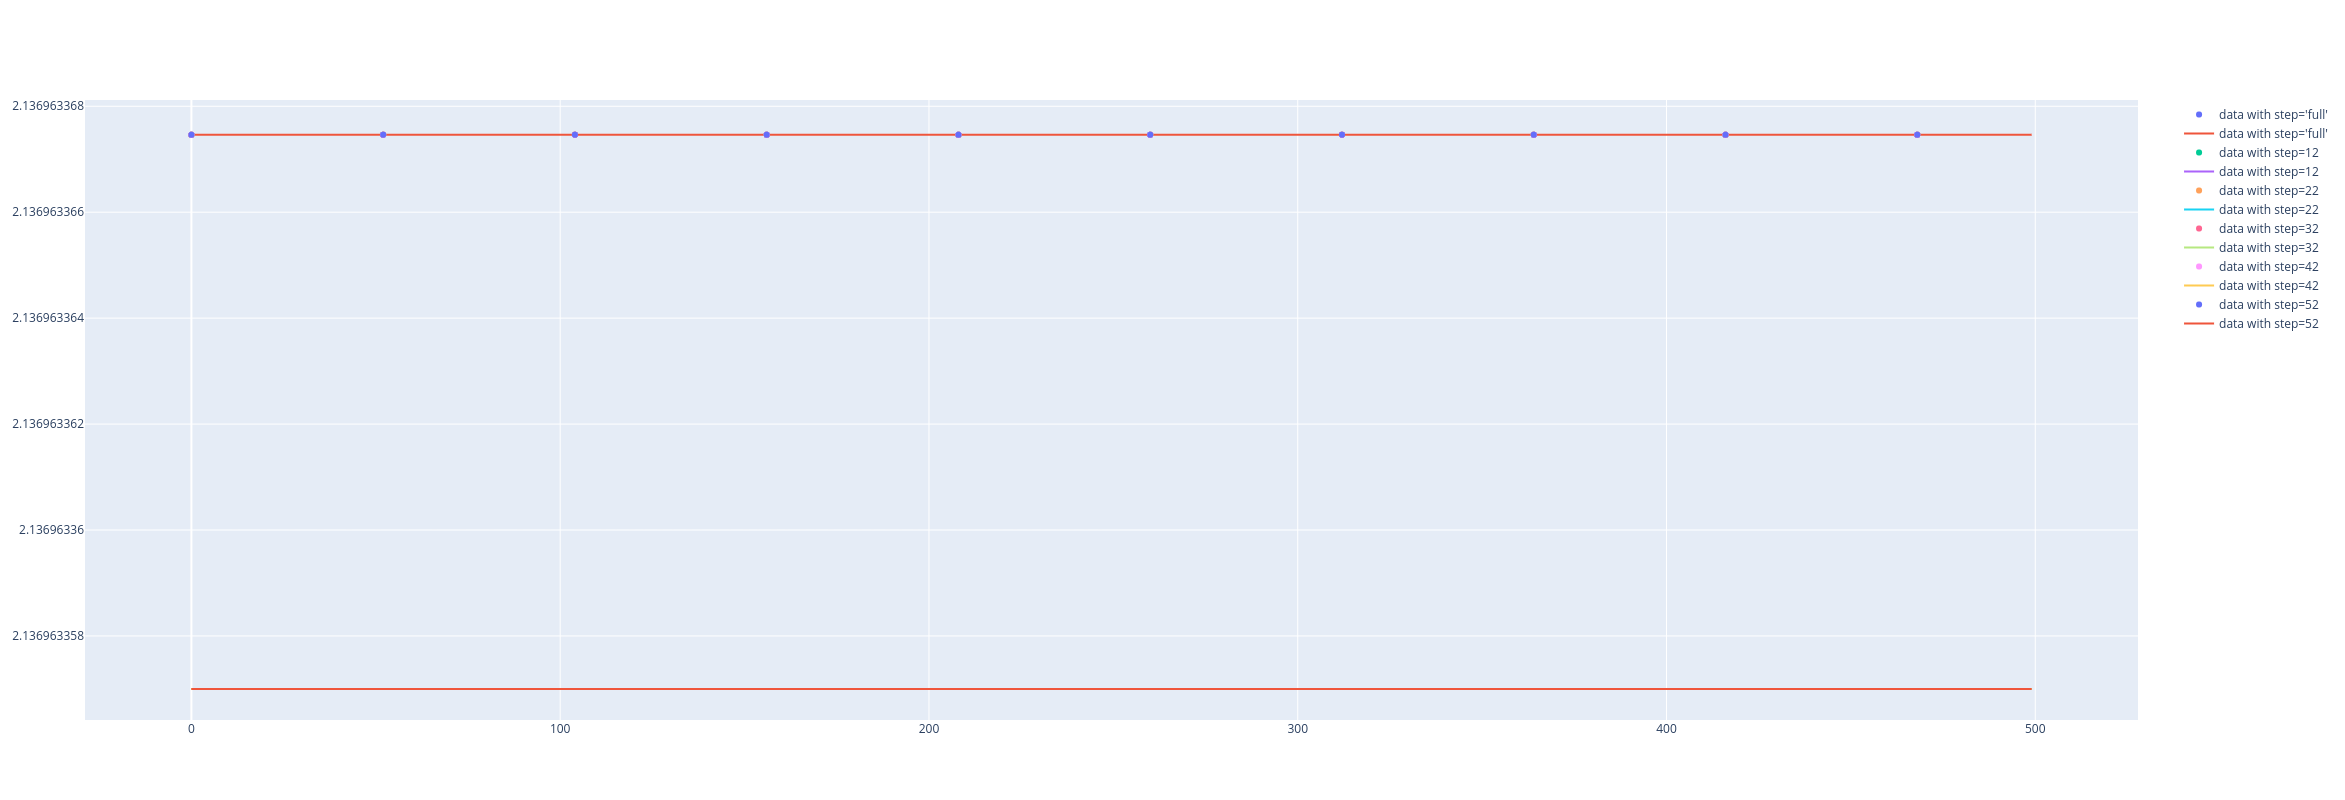

In [17]:
n = 500
fig = go.Figure()
# fig.add_trace(go.Scatter(y=y[:n], name="full"))

for step, x_interp in interps.items():
    if step == 2:
        continue
    fig.add_trace(go.Scatter(y=np.angle(x[:n]), name=f"data with {step=}", mode="markers"))
    fig.add_trace(go.Scatter(y=np.angle(x_interp[:n]), name=f"data with {step=}"))

fig.update_layout(height=800)
fig

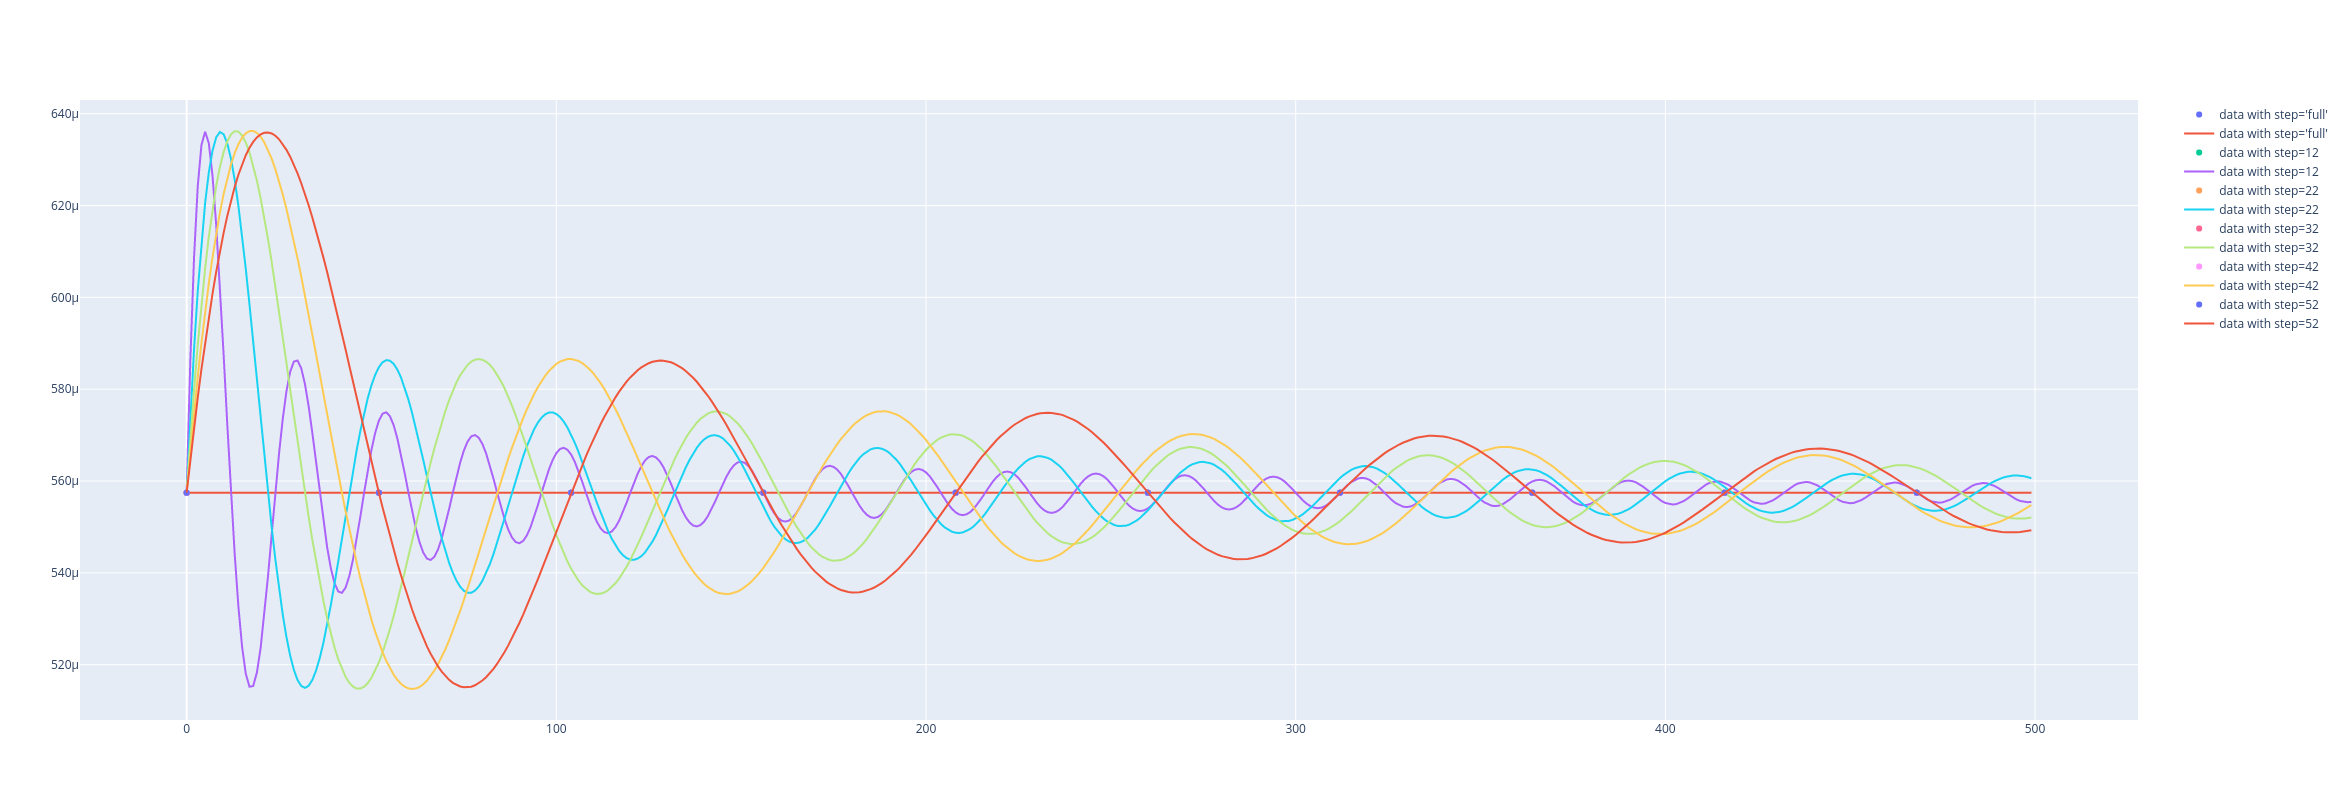

In [18]:
n = 500
fig = go.Figure()
# fig.add_trace(go.Scatter(y=y[:n], name="full"))

for step, x_interp in interps.items():
    if step == 2:
        continue
    fig.add_trace(go.Scatter(y=np.abs(x[:n]), name=f"data with {step=}", mode="markers"))
    fig.add_trace(go.Scatter(y=np.abs(x_interp[:n]), name=f"data with {step=}"))

fig.update_layout(height=800)
fig

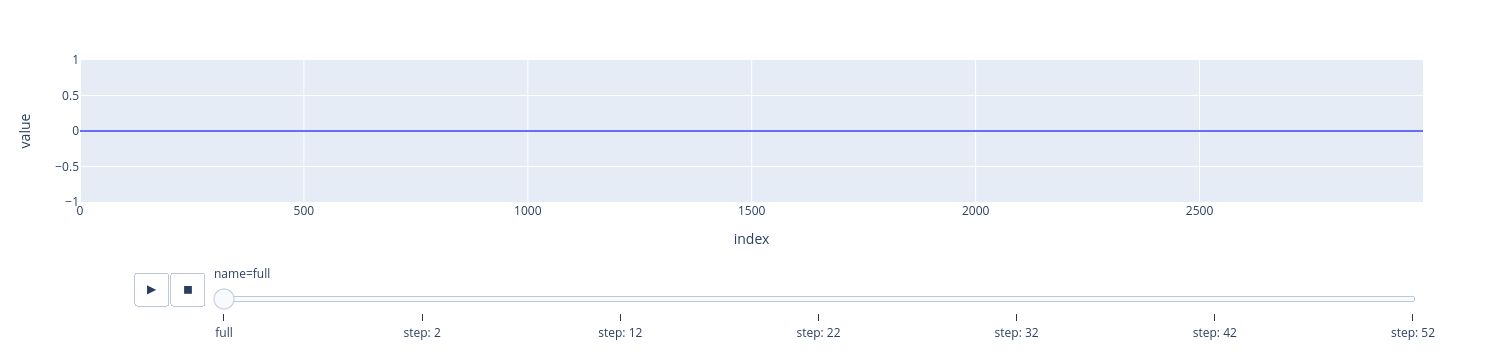

In [62]:
n = 3000
df = pd.DataFrame(
    [
        (f"step: {k}" if isinstance(k, int) else k, i, np.angle(interps[k][i]))
        for k, v in interps.items()
        for i in range(min(len(interps[k]), n))
    ],
    columns=["name", "index", "value"],
)
px.line(
    df,
    y="value",
    x="index",
    animation_frame="name",
    animation_group='index'
)

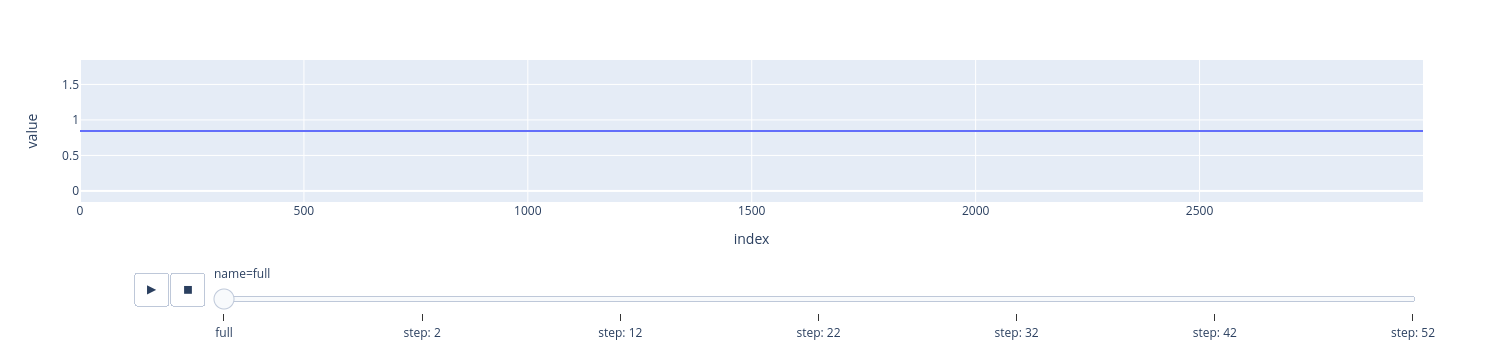

In [63]:
n = 3000
df = pd.DataFrame(
    [
        (f"step: {k}" if isinstance(k, int) else k, i, np.abs(interps[k][i]))
        for k, v in interps.items()
        for i in range(min(len(interps[k]), n))
    ],
    columns=["name", "index", "value"],
)
px.line(
    df,
    y="value",
    x="index",
    animation_frame="name",
    animation_group='index'
)

  0%|          | 0/6 [00:00<?, ?it/s]

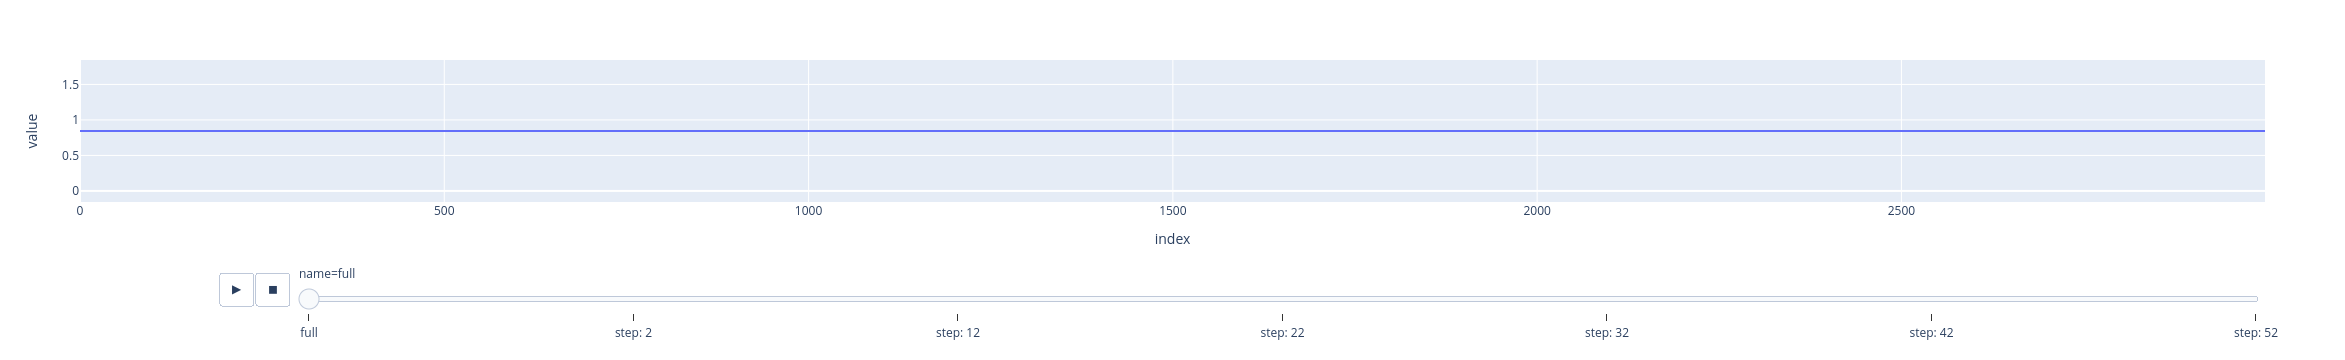

In [21]:
n = 3000

y = np.sin(np.angle(signals_data[0, :n]))
interps = {"full": y}

for step in trange(2, 60, 10):
    x = y.copy()

    x[[True if i % step else False for i in range(len(x))]] = np.nan
    x_interp = wsinterp(
        np.arange(len(x)), np.squeeze(np.argwhere(~np.isnan(x))), x[~np.isnan(x)]
    )
    interps[step] = x_interp
    
df = pd.DataFrame(
    [
        (f"step: {k}" if isinstance(k, int) else k, i, interps[k][i])
        for k, v in interps.items()
        for i in range(len(interps[k]))
    ],
    columns=["name", "index", "value"],
)
px.line(
    df,
    y="value",
    x="index",
    animation_frame="name",
    animation_group='index'
)

https://en.wikipedia.org/wiki/Wiener_filter#:~:text=In%20signal%20processing%2C%20the%20Wiener,noise%20spectra%2C%20and%20additive%20noise.

autoregression